# Formatting your data: feature extraction from motion tracking output

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lucasmiranda42/deepof/blob/master/docs/source/tutorial_notebooks/deepof_preprocessing_tutorial.ipynb)

##### What we'll cover:
    
* Create and run a project.
* Load a previously generated project.
* Interact with your project: generate coordinates, distances, angles, and areas.
* Exploratory visualizations: heatmaps and processed animations.

In [1]:
# # If using Google colab, uncomment and run this cell and the one below to set up the environment
# # Note: becasuse of how colab handles the installation of local packages, this cell will kill your runtime.
# # This is not an error! Just continue with the cells below.
# import os
# !git clone -q https://github.com/mlfpm/deepof.git
# !pip install -q -e deepof --progress-bar off
# os.chdir("deepof")
# !curl --output tutorial_files.zip https://datashare.mpcdf.mpg.de/s/knF7t78isQuIAr0/download
# !unzip tutorial_files.zip
# os.kill(os.getpid(), 9)

In [2]:
# os.chdir("deepof")
# import os, warnings
# warnings.filterwarnings('ignore')

Let's start by importing some packages. We'll use python's os library to handle paths, pickle to load saved objects, pandas to load data frames, and the data entry API within DeepOF, located in deepof.data

In [3]:
import os
import pandas as pd
import pickle
import deepof.data

We'll also need some plotting gear:

In [4]:
import deepof.visuals
import matplotlib.pyplot as plt
import seaborn as sns

### Creating and running a project

With that out of the way, the first thing to do when starting a DeepOF project is to load your videos and DeepLabCut tracking files into a deepof.data.Project object. 

Like depicted in the cell below, the three crucial parameters to input are the project, video and tab paths. 

* project_path specifies where the project folder containing all processing and output files will be created.
* video_path points towards where your DLC or SLEAP labelled videos are stored.
* similarly, table_path should point to the directory containing all tracking files (see section on supported input files below).
* last but not least, you can give your project a name (optional; _deepof_project_ by default).

The dataset used in this tutorial is a subset of the social interaction (SI) dataset used in DeepOF's original paper. It contains six 10-minute-long videos with two animals (a C57Bl6 and a CD1) tracked in a round arena, tracked with DeepLabCut. Three of the C57Bl6 mice have been exposed to chronic social defeat stress (CSDS).

In [5]:
my_deepof_project = deepof.data.Project(
                project_path=os.path.join("tutorial_files"),
                video_path=os.path.join("tutorial_files/Videos/"),
                table_path=os.path.join("tutorial_files/Tables/"),
                project_name="deepof_tutorial_project",
                arena="circular-autodetect",
                animal_ids=["B", "W"],
                table_format="h5",
                video_format=".mp4",
                exclude_bodyparts=["Tail_1", "Tail_2", "Tail_tip"],
                video_scale=380,
                smooth_alpha=1,
                exp_conditions=None,
)

As you may see, there are some extra (optional) parameters in the call above. These specify some details on how the videos and tracks will be processed. Some include:

* arena: some functions within DeepOF (as you will see in the next tutorial on supervised annotations) require the program to detect the arena. The following section explains how to handle this step in more detail.
* animal_ids: in case more than one animal is present in the dataset, the IDs assigned to each during tracking need to be specified as a list. For SLEAP projects, this will be detected automatically, but can be overriten.
* exclude_body_parts: while DeepOF originally relies on 14 body part tracking models, body parts along the tail are no longer used. This step could be bypassed using smaller models following an 11-body-part scheme, such as the one presented in the landing page of the documentation. Custom labelling schemes are also supported (see tutorials).
* video_scale: diameter of the arena (in mm) if circular. In the case of polygonal arenas, the length (in mm) of the first edge as specified in the GUI (see next section) should be provided.
* smooth_alpha: smoothing intensity. The higher the value, the more smoothing is applied.
* exp_conditions: dictionary with a video IDs as keys, and data frames with all experimental conditions as values. DeepOF will use this information to enable all sorts of comparisons between conditions, as we will see in the following tutorials. We'll leave it blank for now and update it afterwards.

For more details, feel free to visit the [full API reference](https://deepof.readthedocs.io/en/latest/#full-api-reference).

Let's then create our first project, by running the `.create()` method in our newly created object:

In [6]:
my_deepof_project = my_deepof_project.create(force=True)

Setting up project directories...
Loading trajectories...
Smoothing trajectories...
Interpolating outliers...
Iterative imputation of ocluded bodyparts...
Detecting arena...
Computing distances...
Computing angles...
Computing areas...
Done!


**NOTE**: the `force` parameter allows DeepOF to override an existing project in the same directory. Use with caution!

**NOTE 2**: the cell above can take a significant amount of time to run in Google colab. Feel free to skip and continue with the loaded results below.

As you will see, this organizes all required file into a folder in the specified path. Moreover, some processing steps are computed on the go, such as distances, angles and areas. This makes it easier for DeepOF to load all required features later on, without the need to compute them every time.

### Arena detection

As mentioned above, one of the key aspects of project creation involves setting up the arena detection mechanism, which will be used in downstream tasks, such as climbing detection and overall video scaling.

You can contrAlong these lines, the package provides tools for detecting elliptical arenas specifically (as seen in this tutorial), and general polygonal shapes (such as squares, rectangles, Y-mazes, etc).

In principle, DeepOF can detect your arenas automatically by relying in [SAM (Segment Anything Model)](https://segment-anything.com/), a state-of-the-art image segmentation deep learning model. By selecting `arena='circular-autodetect'`, or `arena='polygonal-autodetect'`, users can benefit from this approach. A folder named `Arena_detection` will be created in your project directory, which contains samples of the detected arenas for all videos, so you can visually inspect if DeepOF did a good job.



Moreover, manual annotation can be selected using `arena='circular-manual'`, and `arena='polygonal-manual'`. In this case, you will see a window per video appear, allowing you to manually mark where the arena is with just a few clicks. All results will be stored for further processing.

Here, clicking anywhere in the video will make an orange marker appear. In the case of polygonal arenas, at least a marker per corner should be used. When dealing with circular (or elliptical) arenas, DeepOF will fit an ellipse to the marked points after a minimum of 5 clicks. The ellipse can always be refined by adding more markers. Once finished with a video, press `q` to save and move to the next one. If you made a mistake and would like to correct it, press `d` to delete the last added marker. Moreover, after you tagged at least one video, you'll see the `p` option appear, which will copy the last marked arena to all remaining videos in the dataset.

**NOTE**: If you select `arena='polygonal-autodetect'`, you will still be prompted with the GUI to select the arena just once, so SAM roughly knows how the segmentation it should return looks like. Detection in all remaining videos will be automatic. This is not the case for `arena='circular-autodetect'`, as we already know we're looking for a circle.

![arena_GUI](./Assets/arena_GUI.png)

One last thing is that, in polygonal arenas, the first edge you input will be used to scale the coordinates to the proper distances (pixels to millimeters). Make sure you always mark the same edge first, and that it coincides with the length passed to the "video_scale" parameter when creating the project. In saved images of automatically detected polygons, you'll see orange circles marking two arena corners. These should match the first edge you selected when prompting SAM, ensuring data is properly scaled.

If after all this work you make a mistake while labelling, or see that automatic detection failed in some cases, don't worry! You can always edit manually annotated arenas (or rerun automatic annotation) for specific videos using the `.edit_arenas()` method. Just pass a list with the IDs of the videos you would like to relabel, and the GUI will pop up once again. The same methods described above can be passed to the `arena_type` parameter.

**NOTE**: If you don't pass any video IDs, all videos will be selected by default.

In [7]:
my_deepof_project.edit_arenas(
    videos=['20191204_Day2_SI_JB08_Test_54', '20191204_Day2_SI_JB08_Test_62'],
    arena_type="circular-autodetect",
)

Editing 2 arenas
Done!


### Supported input tracking files:

DeepOF currently supports input from both [DeepLabCut](url_here) and [SLEAP](url_here). While DeepOF will try to detect automatically which file type you're trying to use, this can be forced with the `table_format` parameter in the `deepof.data.Project()` call depicted in the previous section.

For DeepLabCut, we support:

* Single and multi-animal project CSV files (indicated simply with `table_format='csv'`.
* Single and multi-animal project h5 files (indicated simply with `table_format='h5'`.

For SLEAP, you can use:

* SLP files (indicated as with `table_format='slp'`.
* Raw .npy files (indicated with `table_format='npy'`.
* h5 files (indicated with `table_format=analysis.h5`.

Downstream processing should be identical regardless of the files selected, as DeepOF internally brings all these inputs into an equivalent representation. Let's continue!

### Loading a previously generated project

Once you ran your project at least once, it can be loaded without much effort from the path you specified in the first place (plus the project name -_deepof_project_, if you didn't specify otherwise-).

In [8]:
# Load a previously saved project
my_deepof_project = deepof.data.load_project("./tutorial_files/deepof_tutorial_project/")
my_deepof_project._project_path

'./tutorial_files/deepof_tutorial_project'

### Extend a previously generated project

If you'd like to add data (videos and tracks) to a previously processed project, you can use the `extend` method instead of `create`. Just pass the path to your previously processed project, and DeepOF will take care of merging the two. A new directory will be created with all files corresponding to the merged projects.

**NOTE**: Your old files will not be deleted.

In [10]:
# Extend a previously saved project
my_deepof_project = my_deepof_project.extend("./tutorial_files/deepof_tutorial_project/")

### Interacting with your project: generating coordinates, distances, angles, and areas.

That's it for basic project creation. We now have a DeepOF project up and running! Before ending the tutorial, however, let's explore the object that the commands above produced.

For starters, if we print it, we see it's a DeepOF analysis of 6 videos. Furthermore, the object belongs to a custom class within DeepOF, called Coordinates. This class allows the package to store all sorts of relevant information required for further processing, as we'll see below:

In [11]:
print(my_deepof_project)
print(type(my_deepof_project))

deepof analysis of 6 videos
<class 'deepof.data.Coordinates'>


As described before, the `.create()` method runs most of the heavy preprocessing already, which allows us to extract features including coordinates, distances, angles, and areas. Let's see how that works!

![preprocessing](./Assets/deepof_preprocessing.png)

With the `.get_coords()` method, for example, we can obtain the processed (smooth and imputed) tracks for all videos in a dictionary. The returned objects are called table dictionaries (TableDict is the name of the class). They follow a dictionary-like structure, where each value is a data frame. They also provide a plethora of extra methods, some of which we'll cover in these tutorials. Let's retrieve these for one of the animals:

In [12]:
my_deepof_project.get_coords(polar=False, center="Center", align="Spine_1")['20191204_Day2_SI_JB08_Test_54']

B_Spine_1            B_Center      B_Left_bhip             \
                           x          y        x    y           x          y   
00:00:00                 0.0  17.041283      0.0  0.0   16.235626  -9.286406   
00:00:00.039935995       0.0  16.475167      0.0  0.0   15.143549 -10.150172   
00:00:00.079871991       0.0  16.446049      0.0  0.0   11.477393 -12.396184   
00:00:00.119807987       0.0  15.217471      0.0  0.0   10.208930 -14.160422   
00:00:00.159743982       0.0  15.037661      0.0  0.0   10.836279 -15.220016   
...                      ...        ...      ...  ...         ...        ...   
00:09:58.800320021       0.0  17.383252      0.0  0.0   15.964064 -11.925356   
00:09:58.840256017       0.0  15.069470      0.0  0.0   15.782188 -13.477302   
00:09:58.880192012       0.0  19.435457      0.0  0.0   12.847697 -11.565332   
00:09:58.920128008       0.0  19.435457      0.0  0.0   12.847697 -11.565332   
00:09:58.960064004       0.0  19.435457      0.0  0.0   12.847697 -11.565332   

                   B_Left_ear            B_Left_fhip             ...  \
                            x          y           x          y  ...   
00:00:00             2.338149  35.826017   14.520708  16.191088  ...   
00:00:00.039935995   0.671672  35.836244   14.183559  14.703795  ...   
00:00:00.079871991   0.097058  35.005123   13.716176  13.898245  ...   
00:00:00.119807987  -0.358944  35.315238   15.230370  11.435026  ...   
00:00:00.159743982   0.861588  34.324995   14.984768  10.471671  ...   
...                       ...        ...         ...        ...  ...   
00:09:58.800320021  10.656661  35.405103   14.810418  11.274649  ...   
00:09:58.840256017   7.241669  39.238723   14.817890   9.091584  ...   
00:09:58.880192012   7.622541  42.242592   14.851511  12.187561  ...   
00:09:58.920128008   7.622541  42.242592   14.851511  12.187561  ...   
00:09:58.960064004   7.622541  42.242592   14.851511  12.187561  ...   

                   W_Right_bhip            W_Right_ear             \
                              x          y           x          y   
00:00:00             -11.115287 -13.877286  -11.056773  52.165913   
00:00:00.039935995   -13.884385 -18.083860  -11.634608  53.793769   
00:00:00.079871991   -15.550991 -13.873025  -12.439161  53.259569   
00:00:00.119807987   -14.469009 -16.138564  -11.961743  52.265874   
00:00:00.159743982   -14.028915 -18.169221  -19.961073  49.485545   
...                         ...        ...         ...        ...   
00:09:58.800320021   -20.815692  -6.861448  -17.302919  31.105013   
00:09:58.840256017   -20.930728  -7.043085  -17.317452  31.011691   
00:09:58.880192012   -20.912197  -7.052485  -17.362287  30.948820   
00:09:58.920128008   -20.912197  -7.052485  -17.362287  30.948820   
00:09:58.960064004   -20.912197  -7.052485  -17.362287  30.948820   

                   W_Right_fhip            W_Spine_2            W_Tail_base  \
                              x          y         x          y           x   
00:00:00             -10.837443  11.900607  1.303025 -19.189055   -9.987794   
00:00:00.039935995   -13.457341  12.356739  1.828954 -24.439299   -1.620732   
00:00:00.079871991   -14.284002  12.808460  0.793345 -21.164099    1.765989   
00:00:00.119807987   -14.571504  13.210702  1.309584 -22.165508    2.815459   
00:00:00.159743982   -14.900604  11.323389  1.955114 -22.447853    2.289354   
...                         ...        ...       ...        ...         ...   
00:09:58.800320021   -12.210518  10.521213 -6.286187 -15.291244  -18.448989   
00:09:58.840256017   -12.259446  10.426808 -6.220324 -15.480332  -18.379192   
00:09:58.880192012   -12.239039  10.390575 -6.179682 -15.503151  -18.331690   
00:09:58.920128008   -12.239039  10.390575 -6.179682 -15.503151  -18.331690   
00:09:58.960064004   -12.239039  10.390575 -6.179682 -15.503151  -18.331690   

                               
                            y  
00:00:00           -46.786090  
00:00:00.039935995 

Note that there are a few parameters you can pass to the `.get_coords()` method. If "polar" is set to True, polar coordinates will be used, instead of Cartesian. Both "center" and "align" control how translational and rotational variance are removed from the data: the former will use the specified body part as [0, 0] (or the center of the arena, if set to "arena"). The latter will rotate the mice on each time point, to align the line connecting the body parts specified in the "center" and "align" parameters with the y-axis.

Furthermore, not only processed coordinates can be retrieved, but also distances, angles, and areas with the .get_distances(), .get_angles(), and .get_areas(), respectively.

In [13]:
my_deepof_project.get_distances()['20191204_Day2_SI_JB08_Test_54']

,"(B_Nose, B_Right_ear)","(B_Tail_base, W_Tail_base)","(W_Center, W_Right_fhip)","(B_Center, B_Left_fhip)","(W_Left_ear, W_Spine_1)","(W_Left_ear, W_Nose)","(B_Tail_base, W_Nose)","(W_Center, W_Spine_2)","(B_Right_bhip, B_Spine_2)","(W_Center, W_Spine_1)",...,"(B_Right_ear, B_Spine_1)","(W_Spine_2, W_Tail_base)","(B_Left_ear, B_Nose)","(B_Center, B_Spine_1)","(B_Nose, W_Tail_base)","(W_Nose, W_Right_ear)","(B_Left_bhip, B_Spine_2)","(W_Center, W_Left_fhip)","(B_Nose, W_Nose)","(B_Spine_2, B_Tail_base)"
00:00:00,18.781728,97.709786,13.041369,17.621480,27.055962,18.834943,148.048046,15.583439,11.304016,19.977755,...,14.239388,24.159109,15.890697,13.807436,115.086175,22.834626,15.229008,18.574999,197.209343,14.568245
00:00:00.039935995,16.395499,102.888817,14.802899,16.552894,25.757160,19.117538,156.962058,19.856936,11.571620,21.885587,...,14.693174,19.898728,15.271448,13.348749,118.018418,21.852281,15.199081,20.296875,201.897777,14.454055
00:00:00.079871991,15.057738,112.513259,15.544880,15.821263,27.572622,22.222081,165.295346,17.159928,11.412604,19.920155,...,14.429184,16.596494,15.170325,13.325157,122.652716,24.791305,14.600725,20.121680,202.543917,14.753496
00:00:00.119807987,15.112614,119.626219,15.936129,15.431171,29.026338,20.982981,171.180259,17.990578,11.977952,20.211183,...,15.581831,16.475699,16.038286,12.329721,122.474901,24.705419,14.741844,19.739289,201.439639,15.937254
00:00:00.159743982,16.235095,123.351461,15.163451,14.811991,26.424186,21.167892,174.253493,18.256880,12.857731,21.018731,...,15.989769,17.803761,18.028338,12.184032,121.775639,22.790681,14.977541,20.680558,200.696460,15.523106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:09:58.800320021,22.674736,231.732647,13.059429,15.081384,18.866566,23.477526,172.650733,13.395564,13.647533,15.129049,...,16.974596,13.522631,20.974634,14.084511,191.389072,19.277812,13.789807,15.207663,148.312574,14.714033
00:09:58.840256017,22.789396,228.571928,13.039802,14.085660,18.910177,23.502572,169.636565,13.517401,13.324808,15.079827,...,17.378502,13.512709,16.403318,12.209805,186.729656,19.322534,13.468828,15.197649,144.670506,14.576626
00:09:58.880192012,21.730112,226.395893,13.008192,15.566291,18.928975,23.463719,168.414230,13.522330,13.673167,15.108134,...,17.947812,13.529974,18.592353,15.747278,186.008429,19.336323,13.742711,15.241505,146.851047,15.374270
00:09:58.920128008,21.730112,226.395893,13.008192,15.566291,18.928975,23.463719,168.414230,13.522330,13.673167,15.108134,...,17.947812,13.529974,18.592353,15.747278,186.008429,19.336323,13.742711,15.241505,146.851047,15.374270


In [14]:
my_deepof_project.get_angles()['20191204_Day2_SI_JB08_Test_54']

,"(B_Left_ear, B_Nose, B_Right_ear)","(B_Nose, B_Left_ear, B_Spine_1)","(B_Right_fhip, B_Center, B_Spine_2)","(B_Right_fhip, B_Center, B_Left_fhip)","(B_Right_fhip, B_Center, B_Spine_1)","(B_Spine_2, B_Center, B_Left_fhip)","(B_Spine_2, B_Center, B_Spine_1)","(B_Left_fhip, B_Center, B_Spine_1)","(B_Left_bhip, B_Spine_2, B_Center)","(B_Left_bhip, B_Spine_2, B_Right_bhip)",...,"(W_Left_bhip, W_Spine_2, W_Center)","(W_Left_bhip, W_Spine_2, W_Right_bhip)","(W_Left_bhip, W_Spine_2, W_Tail_base)","(W_Center, W_Spine_2, W_Right_bhip)","(W_Center, W_Spine_2, W_Tail_base)","(W_Right_bhip, W_Spine_2, W_Tail_base)","(W_Nose, W_Right_ear, W_Spine_1)","(W_Left_ear, W_Spine_1, W_Center)","(W_Left_ear, W_Spine_1, W_Right_ear)","(W_Center, W_Spine_1, W_Right_ear)"
00:00:00,1.222277,1.422657,1.805680,1.281616,1.342828,0.880634,1.020852,1.157763,1.110616,1.293108,...,0.931157,0.848570,0.884871,0.865821,0.905761,0.866423,1.181972,1.145697,1.162453,1.018039
00:00:00.039935995,1.306489,1.247439,1.370046,1.299858,1.296478,1.502996,1.503997,1.052589,1.150996,1.200270,...,0.994129,0.891450,0.966073,0.853879,0.919997,0.829069,1.212442,1.149331,1.114826,1.044152
00:00:00.079871991,1.282906,1.033643,1.190446,1.295514,1.433251,1.331724,1.469462,1.398862,1.548047,1.722389,...,1.017974,0.977607,0.900188,0.915664,0.838244,0.740774,1.069299,1.090081,1.214856,1.133077
00:00:00.119807987,1.251990,1.454675,1.765511,1.277808,1.363800,0.915767,1.064082,1.182411,1.116587,1.309047,...,0.968484,0.885802,0.910080,0.903568,0.931403,0.882201,1.213669,1.177122,1.188797,1.039895
00:00:00.159743982,1.330860,1.264571,1.356475,1.286804,1.286837,1.450061,1.454712,1.065928,1.106752,1.156228,...,1.003958,0.907370,0.988059,0.879502,0.953687,0.854115,1.254271,1.189981,1.148939,1.079375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:09:58.800320021,1.249109,1.107626,0.859565,0.832034,0.888055,0.753215,0.805548,0.793002,0.664003,0.694227,...,0.006698,0.026468,0.016655,0.036679,0.036456,0.152219,0.049799,0.096655,0.082662,0.071047
00:09:58.840256017,1.097980,0.939944,0.779166,0.870837,0.946506,0.793762,0.862571,0.836612,0.737746,0.738258,...,0.104709,0.167571,0.107108,0.170584,0.116224,0.140526,0.030954,0.026903,0.110395,0.121503
00:09:58.880192012,1.062318,1.104193,0.861663,0.853209,0.904947,0.707809,0.759548,0.837450,0.711801,0.763568,...,0.054504,0.049245,0.078203,0.145142,0.174100,0.247217,0.180157,0.128315,0.004496,0.090246
00:09:58.920128008,1.271455,1.135542,0.861166,0.833963,0.890707,0.749906,0.802551,0.806550,0.667206,0.697214,...,0.003272,0.021836,0.011959,0.027468,0.026288,0.141577,0.061570,0.109516,0.093470,0.063343


In [15]:
my_deepof_project.get_areas()['20191204_Day2_SI_JB08_Test_54']

,B_head_area,B_torso_area,B_back_area,B_full_area,W_head_area,W_torso_area,W_back_area,W_full_area
00:00:00,287.018462,467.472460,513.431000,1697.086099,588.316685,575.287843,557.837678,2402.446220
00:00:00.039935995,298.006089,461.593907,511.611552,1664.187297,532.941463,711.610814,747.171324,2612.577515
00:00:00.079871991,283.907493,436.994147,491.022208,1571.659017,615.224965,659.274363,696.773878,2680.819039
00:00:00.119807987,336.017364,459.434553,495.609970,1674.157290,664.955274,698.278394,709.587295,2725.074795
00:00:00.159743982,338.565821,456.785954,510.514167,1706.762126,589.501549,713.393985,706.975280,2732.936140
...,...,...,...,...,...,...,...,...
00:09:58.800320021,364.598702,512.092068,562.957165,1882.932433,516.368794,466.566421,607.161201,1974.352930
00:09:58.840256017,342.771541,514.231920,543.299019,1832.083470,517.334943,468.582411,611.765902,1979.455000
00:09:58.880192012,388.332158,529.127829,558.340318,1889.399535,516.875687,468.401897,613.444346,1980.834529
00:09:58.920128008,388.332158,529.127829,558.340318,1889.399535,516.875687,468.401897,613.444346,1980.834529


Last but not least, features can be merged using the `.merge()` method, which can yield combinations of features if needed. For example, the code in the following cell creates an object with both coordinates and areas per time point:

In [16]:
my_deepof_project.get_coords().merge(my_deepof_project.get_areas())['20191204_Day2_SI_JB08_Test_54']

,"(B_Center, x)","(B_Center, y)","(B_Left_bhip, x)","(B_Left_bhip, y)","(B_Left_ear, x)","(B_Left_ear, y)","(B_Left_fhip, x)","(B_Left_fhip, y)","(B_Nose, x)","(B_Nose, y)",...,"(W_Tail_base, x)","(W_Tail_base, y)",B_head_area,B_torso_area,B_back_area,B_full_area,W_head_area,W_torso_area,W_back_area,W_full_area
00:00:00,223.193283,184.124115,222.160935,202.799423,191.852982,166.609666,201.709718,187.509186,188.298004,147.322081,...,321.353759,97.605996,287.018462,467.472460,513.431000,1697.086099,588.316685,575.287843,557.837678,2402.446220
00:00:00.039935995,222.081848,185.302109,221.340759,203.517593,192.753159,164.698335,201.841401,188.076859,194.544312,145.935454,...,332.379546,98.838112,298.006089,461.593907,511.611552,1664.187297,532.941463,711.610814,747.171324,2612.577515
00:00:00.079871991,220.547333,186.246719,219.854218,203.126160,197.765198,159.669617,201.092896,184.567551,205.235306,142.500976,...,350.856689,101.147659,283.907493,436.994147,491.022208,1571.659017,615.224965,659.274363,696.773878,2680.819039
00:00:00.119807987,218.467209,184.700256,216.118439,201.998322,202.173355,153.366486,199.648239,181.772736,214.989639,138.281066,...,361.710663,101.918587,336.017364,459.434553,495.609970,1674.157290,664.955274,698.278394,709.587295,2725.074795
00:00:00.159743982,219.402542,182.458069,214.480026,200.481461,206.756088,150.536057,201.725708,177.796661,221.262161,133.663879,...,369.073914,106.446114,338.565821,456.785954,510.514167,1706.762126,589.501549,713.393985,706.975280,2732.936140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:09:58.800320021,108.366647,302.971861,127.398353,297.067658,106.577644,339.902678,118.557281,318.548034,91.342528,360.831938,...,267.896393,517.758606,364.598702,512.092068,562.957165,1882.932433,516.368794,466.566421,607.161201,1974.352930
00:09:58.840256017,108.605596,310.532362,127.530082,302.013032,104.571034,350.229231,120.285217,323.409210,93.433890,367.135740,...,267.855316,517.770020,342.771541,514.231920,543.299019,1832.083470,517.334943,468.582411,611.765902,1979.455000
00:09:58.880192012,108.844546,318.092862,124.715041,311.241029,102.564423,360.555784,119.021164,334.388275,86.603620,377.042506,...,267.961975,517.801758,388.332158,529.127829,558.340318,1889.399535,516.875687,468.401897,613.444346,1980.834529
00:09:58.920128008,108.844546,318.092862,124.715041,311.241029,102.564423,360.555784,119.021164,334.388275,86.603620,377.042506,...,267.961975,517.801758,388.332158,529.127829,558.340318,1889.399535,516.875687,468.401897,613.444346,1980.834529


### Loading experimental conditions

So far, DeepOF does not know to which condition each animal belongs. This can be either set up when creating the project (as described above) or specified afterward using the `.load_exp_conditions()` method. We just need to pass the path to a CSV file containing all conditions per animal as extra columns. The only hard requirement is that the first column should have the experiment IDs.

Here is an example:

In [17]:
pd.read_csv("./tutorial_files/tutorial_project/Coordinates/tutorial_exp_conditions.csv", index_col=0)

,experiment_id,CSDS
0,20191204_Day2_SI_JB08_Test_54,Nonstressed
1,20191204_Day2_SI_JB08_Test_56,Stressed
2,20191204_Day2_SI_JB08_Test_61,Stressed
3,20191204_Day2_SI_JB08_Test_62,Stressed
4,20191204_Day2_SI_JB08_Test_63,Nonstressed
5,20191204_Day2_SI_JB08_Test_64,Nonstressed


Great! Now that we understand how the CSV should be formatted, let's then load it onto our project:

In [18]:
my_deepof_project.load_exp_conditions("./tutorial_files/tutorial_project/Coordinates/tutorial_exp_conditions.csv")

And we're done!. Let's explore what's in there with the .get_exp_conditions property:

In [19]:
print(my_deepof_project.get_exp_conditions)

{'20191204_Day2_SI_JB08_Test_54':           CSDS
0  Nonstressed, '20191204_Day2_SI_JB08_Test_56':        CSDS
1  Stressed, '20191204_Day2_SI_JB08_Test_61':        CSDS
2  Stressed, '20191204_Day2_SI_JB08_Test_62':        CSDS
3  Stressed, '20191204_Day2_SI_JB08_Test_63':           CSDS
4  Nonstressed, '20191204_Day2_SI_JB08_Test_64':           CSDS
5  Nonstressed}


We can see that the property retrieves a dictionary with all animal experiments as keys, and data frames with conditions as values. Although in this case we only have the CSDS condition, which can take two values ("Nonstressed" and "Stressed", with three animals each), adding more just requires us to add extra columns to the CSV file.

### Filtering DeepOF objects

Now that experimental conditions were added, we'll explore some filtering tools that DeepOF provides for table dictionary objects.

For starters, imagine you want to subset your data to only contain stressed animals. You can do that with the `.filter_condition()` method, which takes a dictionary as input with the experimental condition to filter on as key, and the value you'd like to keep as value:

In [20]:
# Let's use coords as an example
coords = my_deepof_project.get_coords()
print("The original dataset has {} videos".format(len(coords)))

# Let's keep only those experiments where the subject is stressed:
coords = coords.filter_condition({"CSDS": "Stressed"})
print("The filtered dataset has only {} videos".format(len(coords)))

The original dataset has 6 videos
The filtered dataset has only 3 videos


We can also filter specific experiments with the `.filter_videos()` method, which takes a list of experiment IDs as input:

In [21]:
single_video_coords = coords.filter_videos(['20191204_Day2_SI_JB08_Test_56'])
print("The new filtered dataset has only {} video".format(len(single_video_coords)))

The new filtered dataset has only 1 video


Last but not least, we can also keep all videos, but filter certain animals whose coordinates we'd like to keep for further analysis. As seen above, the dataset used in this tutorial contains two animals per video: a C57Bl6 (labelled "B") and a CD1 (labelled "W"). Let's see how we can keep only the C57B16 with the `.filter_id()` method:

Let's first point out that, before filtering, a given experiment in the coords object has 44 features (22 from each animal).

In [22]:
coords['20191204_Day2_SI_JB08_Test_56']

B_Center             B_Left_bhip              \
                             x           y           x           y   
00:00:00            538.363647  249.284027  552.938171  238.256393   
00:00:00.039938658  538.369385  249.327469  552.927368  238.261719   
00:00:00.079877316  538.341919  249.331680  552.979980  238.308563   
00:00:00.119815975  538.328064  249.476318  553.003174  238.238953   
00:00:00.159754633  538.361267  249.156189  552.935913  238.178787   
...                        ...         ...         ...         ...   
00:09:58.800306707  417.213013  120.369354  434.364075  121.799324   
00:09:58.840245366  418.764465  121.211830  437.265686  124.925872   
00:09:58.880184024  417.745423  119.924720  436.591827  123.725265   
00:09:58.920122683  417.745423  119.924720  436.591827  123.725265   
00:09:58.960061341  417.745423  119.924720  436.591827  123.725265   

                    B_Left_ear             B_Left_fhip              \
                             x           y           x           y   
00:00:00            526.389221  298.484528  554.218140  263.846924   
00:00:00.039938658  526.412781  298.484711  554.220703  263.867645   
00:00:00.079877316  526.437988  298.471222  554.231751  263.856079   
00:00:00.119815975  526.427002  298.530182  554.242981  263.896118   
00:00:00.159754633  526.232361  298.454224  554.304565  263.707153   
...                        ...         ...         ...         ...   
00:09:58.800306707  407.657898  149.051193  420.671143  132.926590   
00:09:58.840245366  408.706879  148.632080  423.572205  135.010574   
00:09:58.880184024  407.754945  145.980683  422.490540  133.576019   
00:09:58.920122683  407.754945  145.980683  422.490540  133.576019   
00:09:58.960061341  407.754945  145.980683  422.490540  133.576019   

                        B_Nose              ... W_Right_ear              \
                             x           y  ...           x           y   
00:00:00            497.151367  300.893616  ...  163.311036  230.528197   
00:00:00.039938658  497.139038  300.743500  ...  167.872041  221.538756   
00:00:00.079877316  497.157898  300.888397  ...  172.082931  213.227768   
00:00:00.119815975  497.196014  300.982727  ...  176.770797  203.171585   
00:00:00.159754633  497.193512  300.888733  ...  184.708252  193.616104   
...                        ...         ...  ...         ...         ...   
00:09:58.800306707  403.773225  168.571396  ...  458.965545  138.696243   
00:09:58.840245366  403.317353  167.953598  ...  459.109069  139.845016   
00:09:58.880184024  404.400087  162.526779  ...  459.507567  142.085800   
00:09:58.920122683  404.400087  162.526779  ...  459.507567  142.085800   
00:09:58.960061341  404.400087  162.526779  ...  459.507567  142.085800   

                   W_Right_fhip               W_Spine_1              \
                              x           y           x           y   
00:00:00             151.194123  260.958313  145.208389  245.764724   
00:00:00.039938658   156.158676  252.000641  147.822707  238.749525   
00:00:00.079877316   160.587585  244.264328  151.865173  229.841355   
00:00:00.119815975   164.369293  235.348343  156.897583  219.281571   
00:00:00.159754633   168.269272  226.879074  161.464935  209.005005   
...                         ...         ...         ...         ...   
00:09:58.800306707   478.439513  152.962585  464.861633  161.004669   
00:09:58.840245366   480.203215  153.216278  465.769653  161.612426   
00:09:58.880184024   482.209348  155.651763  468.152923  164.586746   
00:09:58.920122683   482.209348  155.651763  468.152923  164.586746   
00:09:58.960061341   482.209348  155.651763  468.152923  164.586746   

                     W_Spine_2             W_Tail_base              
                             x           y           x           y  
00:00:00            123.380149  292.024324  117.470673  316.318786  
00:00:00.039938658  126.308410  282.404055  117.764466  305.007018  
00:00:00.079877316  129.

After filtering to keep only the C57Bl6 ("B"), there are only 22 features left (scroll right to see that, as expected, no features related to "W" remain):

In [23]:
coords.filter_id("B")['20191204_Day2_SI_JB08_Test_56']

B_Center             B_Left_bhip              \
                             x           y           x           y   
00:00:00            538.363647  249.284027  552.938171  238.256393   
00:00:00.039938658  538.369385  249.327469  552.927368  238.261719   
00:00:00.079877316  538.341919  249.331680  552.979980  238.308563   
00:00:00.119815975  538.328064  249.476318  553.003174  238.238953   
00:00:00.159754633  538.361267  249.156189  552.935913  238.178787   
...                        ...         ...         ...         ...   
00:09:58.800306707  417.213013  120.369354  434.364075  121.799324   
00:09:58.840245366  418.764465  121.211830  437.265686  124.925872   
00:09:58.880184024  417.745423  119.924720  436.591827  123.725265   
00:09:58.920122683  417.745423  119.924720  436.591827  123.725265   
00:09:58.960061341  417.745423  119.924720  436.591827  123.725265   

                    B_Left_ear             B_Left_fhip              \
                             x           y           x           y   
00:00:00            526.389221  298.484528  554.218140  263.846924   
00:00:00.039938658  526.412781  298.484711  554.220703  263.867645   
00:00:00.079877316  526.437988  298.471222  554.231751  263.856079   
00:00:00.119815975  526.427002  298.530182  554.242981  263.896118   
00:00:00.159754633  526.232361  298.454224  554.304565  263.707153   
...                        ...         ...         ...         ...   
00:09:58.800306707  407.657898  149.051193  420.671143  132.926590   
00:09:58.840245366  408.706879  148.632080  423.572205  135.010574   
00:09:58.880184024  407.754945  145.980683  422.490540  133.576019   
00:09:58.920122683  407.754945  145.980683  422.490540  133.576019   
00:09:58.960061341  407.754945  145.980683  422.490540  133.576019   

                        B_Nose              ... B_Right_ear              \
                             x           y  ...           x           y   
00:00:00            497.151367  300.893616  ...  515.534424  278.740295   
00:00:00.039938658  497.139038  300.743500  ...  515.557556  278.727722   
00:00:00.079877316  497.157898  300.888397  ...  515.525696  278.735718   
00:00:00.119815975  497.196014  300.982727  ...  515.538391  278.738708   
00:00:00.159754633  497.193512  300.888733  ...  515.538025  278.705048   
...                        ...         ...  ...         ...         ...   
00:09:58.800306707  403.773225  168.571396  ...  389.377777  147.743684   
00:09:58.840245366  403.317353  167.953598  ...  389.137940  146.219651   
00:09:58.880184024  404.400087  162.526779  ...  387.196167  144.977769   
00:09:58.920122683  404.400087  162.526779  ...  387.196167  144.977769   
00:09:58.960061341  404.400087  162.526779  ...  387.196167  144.977769   

                   B_Right_fhip               B_Spine_1              \
                              x           y           x           y   
00:00:00             524.835266  258.351959  536.314819  269.603027   
00:00:00.039938658   524.861694  258.385285  536.332397  269.632355   
00:00:00.079877316   524.850891  258.373383  536.320923  269.619812   
00:00:00.119815975   524.852112  258.445496  536.338318  269.629272   
00:00:00.159754633   524.844055  258.242065  536.360901  269.499512   
...                         ...         ...         ...         ...   
00:09:58.800306707   402.071594  119.623657  406.150024  129.519211   
00:09:58.840245366   402.076691  119.482201  407.196777  129.546539   
00:09:58.880184024   399.367402  117.643234  406.196411  127.711792   
00:09:58.920122683   399.367402  117.643234  406.196411  127.711792   
00:09:58.960061341   399.367402  117.643234  406.196411  127.711792   

                     B_Spine_2             B_Tail_base              
                             x           y           x           y  
00:00:00            536.819580  230.367477  530.644226  211.947082  
00:00:00.039938658  536.820496  230.371612  530.645569  211.948883  
00:00:00.079877316  536.

Now that we have a basic understanding of how to create and interact with a project, coordinates, and table dictionaries, let's show some plots!

### Basic visual exploration

Let's first see some basic heatmaps per condition. All plotting functions within DeepOF are hosted in the deepof.visuals module. Among many other things, we can plot average heatmaps per experimental condition! Let's see if we can visualize ant interesting patterns on the available data:

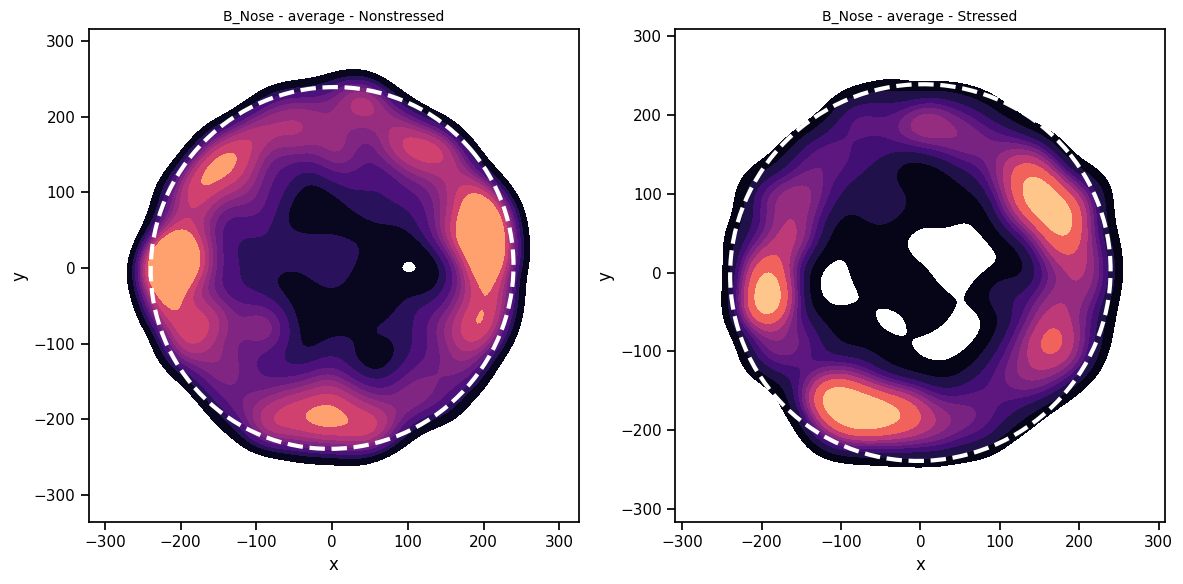

In [24]:
sns.set_context("notebook")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

deepof.visuals.plot_heatmaps(
    my_deepof_project, 
    ["B_Nose"],
    center="arena", 
    exp_condition="CSDS",
    condition_value="Nonstressed",
    ax=ax1,
    show=False,
    display_arena=True,
    experiment_id="average",
)

deepof.visuals.plot_heatmaps(
    my_deepof_project,
    ["B_Nose"],
    center="arena", 
    exp_condition="CSDS",
    condition_value="Stressed",
    ax=ax2,
    show=False,
    display_arena=True,
    experiment_id="average",
)

plt.tight_layout()
plt.show()

It seems stressed animals spend more time closer to the walls of the arena, and less time in the center! For details on how deepof.visuals.plot_heatmap() works, feel free to check the full API reference or the function docstring.

Finally, let's create an animated video showing our newly preprocessed data. DeepOF can produce reconstructions of the tracks and show them as videos. All animals and the arena are displayed by default. This is particularly useful when interpreting clusters and visualizing embeddings in the unsupervised pipeline, as we'll see in a later turorial.

In [25]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    experiment_id="20191204_Day2_SI_JB08_Test_54",
    frame_limit=500,
    dpi=60,
)

html = display.HTML(video)
display.display(html)
plt.close()

### What's next

That's it for this tutorial. [Next](https://deepof.readthedocs.io/en/latest/tutorial_notebooks/deepof_supervised_tutorial.html), we'll see how to run a supervised annotation pipeline with pretrained models!